In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import jax.numpy as jnp  
import jax  
from flax import linen as nn  
from sklearn.preprocessing import MinMaxScaler  
from jax.example_libraries import optimizers 

In [2]:
ticker = ["ITC.NS", "IRCTC.NS", "BANDHANBNK.NS", "ZOMATO.NS", "^NSEI.NS"]

In [3]:
# Load and preprocess data
df = pd.read_csv("collected_data.csv")  
df = df[['Date', 'Close']]  
df['Date'] = pd.to_datetime(df['Date'])  
df.set_index('Date', inplace=True)  
scaler = MinMaxScaler(feature_range=(0,1))  
df_scaled = scaler.fit_transform(df)

In [4]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return jnp.array(X), jnp.array(y)

seq_length = 60  
X, y = create_sequences(df_scaled, seq_length)
split = int(0.8 * len(X))  
X_train, X_test = X[:split], X[split:]  
y_train, y_test = y[:split], y[split:]  

In [5]:
# Define LSTM Model using Flax
class LSTMModel(nn.Module):
    hidden_size: int  # Number of LSTM units
    output_size: int  # Final output size

    @nn.compact
    def __call__(self, x):
        batch_size, seq_len, _ = x.shape
        
        lstm_cell = nn.OptimizedLSTMCell(self.hidden_size)  # Use Flax's optimized LSTM cell
        carry = lstm_cell.initialize_carry(jax.random.PRNGKey(0), (batch_size, self.hidden_size))  # Correct shape
        
        # Process sequence through LSTM
        for t in range(seq_len):
            carry, x_t = lstm_cell(carry, x[:, t, :])  # Update state at each timestep
        
        x = nn.Dense(self.output_size)(x_t)  # Fully connected layer
        return x

# Initialize model
model = LSTMModel(hidden_size=50, output_size=25)

# Example input: (batch_size=1, seq_len=50, input_features=1)
params = model.init(jax.random.PRNGKey(0), jnp.ones((1, 50, 1)))

print("✅ Model initialized successfully!")

✅ Model initialized successfully!


In [6]:
# Initialize model
model = LSTMModel(hidden_size=50, output_size=25)
params = model.init(jax.random.PRNGKey(0), X_train)  

# Define loss function
def loss_fn(params, X, y):
    preds = model.apply(params, X)
    return jnp.mean((preds - y) ** 2)

In [7]:
# Train the model
opt_init, opt_update, get_params = optimizers.adam(0.001)
opt_state = opt_init(params)

@jax.jit
def step(i, opt_state, X, y):
    params = get_params(opt_state)
    loss, grads = jax.value_and_grad(loss_fn)(params, X, y)
    return opt_update(i, grads, opt_state), loss

for epoch in range(50):
    opt_state, loss = step(epoch, opt_state, X_train, y_train)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

Epoch 0, Loss: 0.29258811473846436
Epoch 10, Loss: 0.15528647601604462
Epoch 20, Loss: 0.07254208624362946
Epoch 30, Loss: 0.02471683733165264
Epoch 40, Loss: 0.007126139011234045


In [8]:
# Make predictions
final_params = get_params(opt_state)
y_pred = model.apply(final_params, X_test)
y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))  
y_test = scaler.inverse_transform(np.array(y_test).reshape(-1, 1)) 

In [17]:
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

y_test_flat.shape, y_pred_flat.shape

((235,), (5875,))

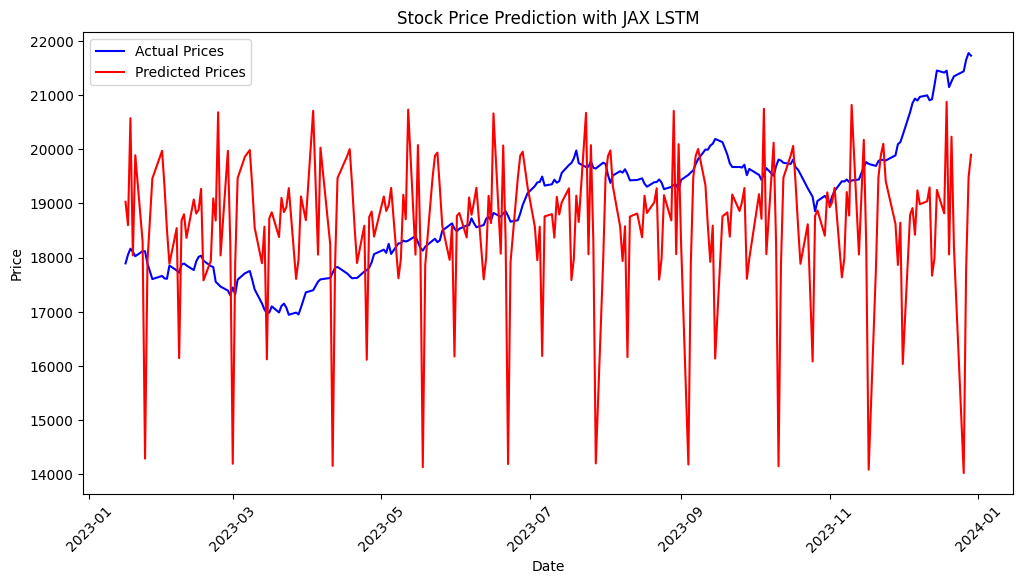

In [28]:
# Flatten y_test and y_pred to match the x-axis length
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Ensure the lengths of y_test_flat and y_pred_flat match the x-axis
x_axis = df.index[-len(y_test_flat):]  # Use the last 'len(y_test_flat)' dates
y_pred_flat = y_pred_flat[-len(y_test_flat):]  # Slice y_pred_flat to match y_test_flat

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(x_axis, y_test_flat, label="Actual Prices", color="blue")  # Use dates for x-axis
plt.plot(x_axis, y_pred_flat, label="Predicted Prices", color="red")  # Use dates for x-axis
plt.legend()
plt.title("Stock Price Prediction with JAX LSTM")
plt.xlabel("Date")  # Add x-axis label
plt.ylabel("Price")  # Add y-axis label
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

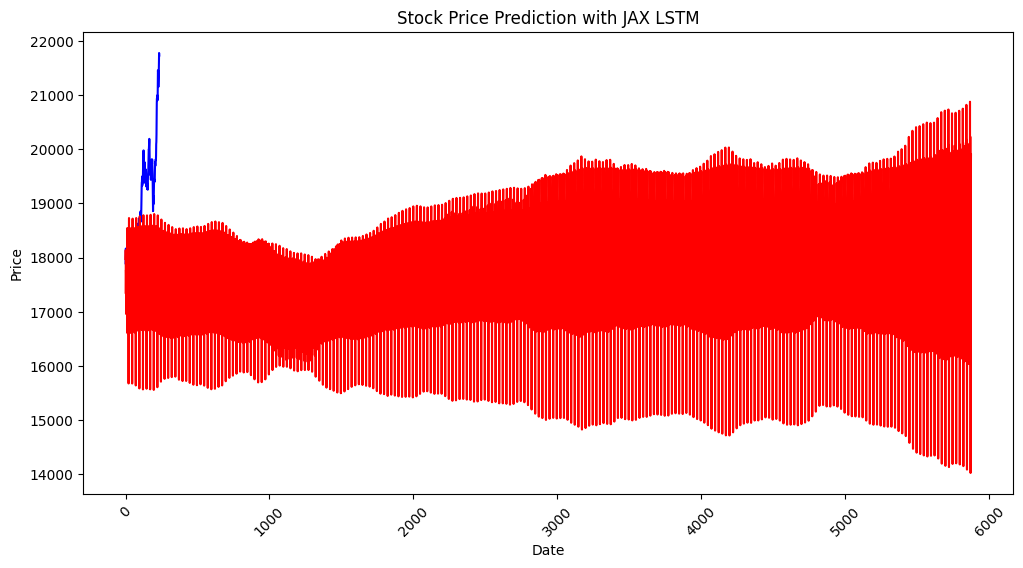

In [ ]:
# Old Code for plotting without dates

# Plot results
plt.figure(figsize=(12,6))
plt.plot(y_test, label="Actual Prices", color="blue")
plt.plot(y_pred, label="Predicted Prices", color="red")
plt.title("Stock Price Prediction with JAX LSTM")
plt.xlabel("Date")  # Add x-axis label
plt.ylabel("Price")  # Add y-axis label
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()